<a href="https://www.kaggle.com/code/suprithhattikal/toxiccommentdetection?scriptVersionId=94835839" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
import gensim
import string
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
import warnings
from keras import backend as K
warnings.filterwarnings("ignore")
tf.config.list_physical_devices('GPU')


train_df = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv', index_col='id', engine='python',error_bad_lines=False)
test_df = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv', index_col='id', engine='python',error_bad_lines=False)

import nltk
nltk.download('stopwords')

stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))

def preprocess(text_string):
    text_string = text_string.lower() # Convert everything to lower case.
    text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) # Remove special characters and punctuations
    
    x = text_string.split()
    new_text = []
    
    for word in x:
        if word not in stop_words:
            new_text.append(stemmer.stem(word))
            
    text_string = ' '.join(new_text)
    return text_string

train_df['preprocessed_text'] = train_df['comment_text'].apply(preprocess)
test_df['preprocessed_text'] = test_df['comment_text'].apply(preprocess)

feature = train_df[['preprocessed_text']]
output = train_df[['target']]
X_train, X_cv, y_train, y_cv = train_test_split(feature, output)

X_test = test_df[['preprocessed_text']]

# Saving the files to csv so that we dont need to preprocess again.
X_train.to_pickle('./X_train.pkl')
X_cv.to_pickle('./X_cv.pkl')
X_test.to_pickle('./X_test.pkl')
y_train.to_pickle('./y_train.pkl')
y_cv.to_pickle('./y_cv.pkl')

# To load the csv files:
# Uncomment the block.
X_train = pd.read_pickle('./X_train.pkl')
X_cv = pd.read_pickle('./X_cv.pkl')
X_test = pd.read_pickle('./X_test.pkl')
y_train = pd.read_pickle('./y_train.pkl')
y_cv = pd.read_pickle('./y_cv.pkl')

cnt_vec = CountVectorizer(ngram_range=(1,2), max_features=30000)
bow_train = cnt_vec.fit_transform(X_train['preprocessed_text'])
bow_cv = cnt_vec.transform(X_cv['preprocessed_text'])
bow_test = cnt_vec.transform(X_test['preprocessed_text'])


# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()


best_model.get_params()
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = cnt_vec.get_feature_names()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]


# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]


# Performing hyperparameter tuning: Decision tree
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

best_model.get_params()

weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]


class LSTMFeaturization:
    
    def __init__(self):
        self.word_mapping = None
        self.total_words = None
        
    
    # Accepts a list of sentences and builds a vocabulary.
    def build_vocabulary(self, sentences):
        
        vocab = set()
        for x in sentences:
            for word in x.split():
                vocab.add(word)
        
        # Create a dictionary from vocabulary.
        vocab_dict = dict.fromkeys(vocab, 0)
        
        # Calculate count of each word..
        for x in sentences:
            for word in x.split():
                vocab_dict[word]+=1
                
        return vocab_dict
    
    
    
    # Accepts a dictionary (vocabulary) and gets the word number in dictionary format
    def get_mapping(self, vocab_dict):
                
        # Get the number of each word into the corpus.
        k = []
        v = []
        for keys,val in vocab_dict.items():
            k.append(keys)
            v.append(val)
            
        kv = np.vstack((k,v)).T
        df = pd.DataFrame(columns=["Word","Count"], data=kv)
        df['Count'] = df['Count'].astype('int')
        
        # Sort the dataframe to get the largest count at first place
        df.sort_values(by=['Count'], ascending=False, inplace=True)
        
        # Give numbering to the most frequent word as 1 then next as 2 and so on.
        df.reset_index(inplace=True)
        df['mapping'] = df.index + 1
        
        df.drop(columns=['index'], inplace=True)
        df.drop(columns=['Count'], inplace=True)
        
        # Convert to dictionary for easier processing.
        dictionary = dict(zip(df['Word'], df['mapping']))
        
        return dictionary
    
    
    # Accepts a list of sentences and generates vocabulary and word mappings.
    def fit(self, sentences):
        v = self.build_vocabulary(sentences)
        self.word_mapping = self.get_mapping(v)
        self.total_words = len(self.word_mapping)
        
    # Converts the sentences to number mappings.
    def transform(self, sentences, pad_length = 350):
        
        whole = list() # Stores mapping for all sentences
        for x in sentences: # for each sentence in list of sentences.
            
            part = list()
            for word in x.split(): # for each word
                if word in self.word_mapping:
                    part.append(self.word_mapping[word]) # Append mapped number.
            whole.append(part) # Append sentence.
        
        # Append additional values to make lengths equal.
        whole = keras.preprocessing.sequence.pad_sequences(np.array(whole), maxlen=pad_length)
        
        return whole
lstmfeat = LSTMFeaturization()
lstmfeat.fit(X_train['preprocessed_text'])

lstm_train = lstmfeat.transform(X_train['preprocessed_text'])
lstm_test = lstmfeat.transform(X_test['preprocessed_text'])
lstm_cv = lstmfeat.transform(X_cv['preprocessed_text'])

np.save('./lstm_train.npy', lstm_train)
np.save('./lstm_cv.npy', lstm_cv)
np.save('./lstm_test.npy', lstm_test)

# create the model
embedding_vecor_length = 100
total_words = lstmfeat.total_words
model = Sequential()
model.add(Embedding(total_words ,embedding_vecor_length, input_length=350))
model.add(CuDNNLSTM(128, return_sequences=True))
model.add(CuDNNLSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
print(model.summary())

filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# del train_df
# del test_df

history = model.fit(lstm_train, y_train, epochs=5,batch_size=1024, validation_data=(lstm_cv, y_cv), verbose = 1, callbacks=callbacks_list)
print("Model fit success")

Text(0.5, 1.0, 'Loss Curves')

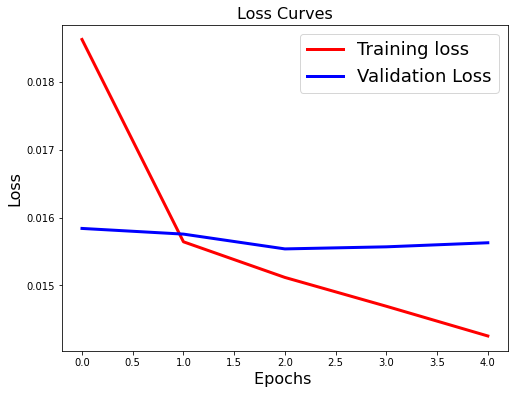

In [5]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [6]:
predictions = model.predict(lstm_test)
predictions

2022-05-05 13:53:03.682886: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 136248000 exceeds 10% of free system memory.


array([[0.01708018],
       [0.0416565 ],
       [0.22757135],
       ...,
       [0.5616949 ],
       [0.15974773],
       [0.02671108]], dtype=float32)